In [ ]:
!git clone https://github.com/jundeli/quantum-gan.git

Cloning into 'quantum-gan'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 262 (delta 51), reused 0 (delta 0), pack-reused 140
Receiving objects: 100% (262/262), 4.17 MiB | 17.42 MiB/s, done.
Resolving deltas: 100% (122/122), done.


In [ ]:
!python -m pip install pennylane
!pip install frechetdist
!pip install kora
import kora.install.rdkit

In [ ]:
import os
os.chdir("/content/quantum-gan/data/")

In [ ]:
%%bash
chmod u+x download_dataset.sh
./download_dataset.sh

gdb9.sdf.csv
gdb9.sdf


--2021-02-05 14:19:10--  http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/gdb9.tar.gz
Resolving deepchem.io.s3-website-us-west-1.amazonaws.com (deepchem.io.s3-website-us-west-1.amazonaws.com)... 52.219.112.75
Connecting to deepchem.io.s3-website-us-west-1.amazonaws.com (deepchem.io.s3-website-us-west-1.amazonaws.com)|52.219.112.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44852087 (43M) [application/x-gzip]
Saving to: ‘gdb9.tar.gz’

     0K .......... .......... .......... .......... ..........  0% 1.01M 42s
    50K .......... .......... .......... .......... ..........  0% 2.02M 32s
   100K .......... .......... .......... .......... ..........  0% 96.8M 21s
   150K .......... .......... .......... .......... ..........  0%  106M 16s
   200K .......... .......... .......... .......... ..........  0% 2.08M 17s
   250K .......... .......... .......... .......... ..........  0%  148M 14s
   300K .......... .......... .......... .......... ....

In [ ]:
!python sparse_molecular_dataset.py

2021-02-05 14:31:47 Extracting gdb9.sdf..
[14:31:47] Warning: molecule is tagged as 3D, but all Z coords are zero
[14:31:47] Explicit valence for atom # 1 C, 5, is greater than permitted
[14:31:47] ERROR: Could not sanitize molecule ending on line 9097
[14:31:47] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[14:31:47] Warning: molecule is tagged as 3D, but all Z coords are zero
[14:31:47] Explicit valence for atom # 1 C, 5, is greater than permitted
[14:31:47] ERROR: Could not sanitize molecule ending on line 35785
[14:31:47] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[14:31:47] Explicit valence for atom # 4 C, 5, is greater than permitted
[14:31:47] ERROR: Could not sanitize molecule ending on line 62866
[14:31:47] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
[14:31:47] Explicit valence for atom # 2 C, 5, is greater than permitted
[14:31:47] ERROR: Could not sanitize molecule ending on line 66832
[14:31:47] ERRO

In [ ]:
os.chdir("/content/quantum-gan/")

In [ ]:
import pennylane as qml
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import pandas as pd
import argparse
import os
import math
import datetime
import time
from frechetdist import frdist

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch
from solver import Solver
from data_loader import get_loader
from torch.backends import cudnn
from utils import *
from models import Generator, Discriminator
from data.sparse_molecular_dataset import SparseMolecularDataset
from rdkit import Chem


In [ ]:
def str2bool(v):
    return v.lower() in ('true')

qubits = 8
# Set up your ibmq credentials first from https://quantum-computing.ibm.com/
demo_on_ibmq = False
#here we are using default device provided by pennylane
if demo_on_ibmq:
    dev = qml.device('qiskit.ibmq', wires=qubits, backend='ibmq_16_melbourne')
else:
    dev = qml.device('default.qubit', wires=qubits)

@qml.qnode(dev, interface='torch')
def gen_circuit(w):
    # random noise as generator input
    #z1 and z2 are random noise parameters.
    z1 = random.uniform(-1, 1)
    z2 = random.uniform(-1, 1)
    #number of layers in the circuit
    layers = 1    
    
    # construct generator circuit for both atom vector and node matrix
    for i in range(qubits):
        qml.RY(np.arcsin(z1), wires=i)
        qml.RZ(np.arcsin(z2), wires=i)
        
    for l in range(layers):
        for i in range(qubits):
            qml.RY(w[i], wires=i)
        for i in range(qubits-1):
            qml.CNOT(wires=[i, i+1])
            qml.RZ(w[i+qubits], wires=i+1)
            qml.CNOT(wires=[i, i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

In [ ]:
parser = argparse.ArgumentParser()

# Quantum circuit configuration
parser.add_argument('--quantum', type=bool, default=True, help='choose to use quantum gan with hybrid generator')
parser.add_argument('--patches', type=int, default=1, help='number of quantum circuit patches')
parser.add_argument('--layer', type=int, default=1, help='number of repeated variational quantum layer')
parser.add_argument('--qubits', type=int, default=8, help='number of qubits and dimension of domain labels')

# Model configuration.
parser.add_argument('--z_dim', type=int, default=8, help='dimension of domain labels')
parser.add_argument('--g_conv_dim', default=[128], help='number of conv filters in the first layer of G')
parser.add_argument('--d_conv_dim', type=int, default=[[128, 64], 128, [128, 64]], help='number of conv filters in the first layer of D')
parser.add_argument('--g_repeat_num', type=int, default=6, help='number of residual blocks in G')
parser.add_argument('--d_repeat_num', type=int, default=6, help='number of strided conv layers in D')
parser.add_argument('--lambda_cls', type=float, default=1, help='weight for domain classification loss')
parser.add_argument('--lambda_rec', type=float, default=10, help='weight for reconstruction loss')
parser.add_argument('--lambda_gp', type=float, default=10, help='weight for gradient penalty')
parser.add_argument('--post_method', type=str, default='softmax', choices=['softmax', 'soft_gumbel', 'hard_gumbel'])

# Training configuration.
parser.add_argument('--batch_size', type=int, default=16, help='mini-batch size')
parser.add_argument('--num_iters', type=int, default=5000, help='number of total iterations for training D')
parser.add_argument('--num_iters_decay', type=int, default=2500, help='number of iterations for decaying lr')
parser.add_argument('--g_lr', type=float, default=0.0001, help='learning rate for G')
parser.add_argument('--d_lr', type=float, default=0.0001, help='learning rate for D')
parser.add_argument('--dropout', type=float, default=0., help='dropout rate')
parser.add_argument('--n_critic', type=int, default=5, help='number of D updates per each G update')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for Adam optimizer')
parser.add_argument('--beta2', type=float, default=0.999, help='beta2 for Adam optimizer')
parser.add_argument('--resume_iters', type=int, default=None, help='resume training from this step')

# Test configuration.
parser.add_argument('--test_iters', type=int, default=5000, help='test model from this step')

# Miscellaneous.
parser.add_argument('--num_workers', type=int, default=1)
parser.add_argument('--mode', type=str, default='train', choices=['train', 'test'])
parser.add_argument('--use_tensorboard', type=str2bool, default=False)

# Directories.
parser.add_argument('--mol_data_dir', type=str, default='data/gdb9_9nodes.sparsedataset')
parser.add_argument('--log_dir', type=str, default='qgan-hg/logs')
parser.add_argument('--model_save_dir', type=str, default='qgan-hg/models')
parser.add_argument('--sample_dir', type=str, default='qgan-hg/samples')
parser.add_argument('--result_dir', type=str, default='qgan-hg/results')

# Step size.
parser.add_argument('--log_step', type=int, default=10)
parser.add_argument('--sample_step', type=int, default=1000)
parser.add_argument('--model_save_step', type=int, default=1000)
parser.add_argument('--lr_update_step', type=int, default=500)

config = parser.parse_known_args()[0]
print(config)

Namespace(batch_size=16, beta1=0.5, beta2=0.999, d_conv_dim=[[128, 64], 128, [128, 64]], d_lr=0.0001, d_repeat_num=6, dropout=0.0, g_conv_dim=[128], g_lr=0.0001, g_repeat_num=6, lambda_cls=1, lambda_gp=10, lambda_rec=10, layer=1, log_dir='qgan-hg/logs', log_step=10, lr_update_step=500, mode='train', model_save_dir='qgan-hg/models', model_save_step=1000, mol_data_dir='data/gdb9_9nodes.sparsedataset', n_critic=5, num_iters=5000, num_iters_decay=2500, num_workers=1, patches=1, post_method='softmax', quantum=True, qubits=8, result_dir='qgan-hg/results', resume_iters=None, sample_dir='qgan-hg/samples', sample_step=1000, test_iters=5000, use_tensorboard=False, z_dim=8)


In [ ]:
self = Solver(config)

Generator(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=True)
  )
  (edges_layer): Linear(in_features=128, out_features=405, bias=True)
  (nodes_layer): Linear(in_features=128, out_features=45, bias=True)
  (dropoout): Dropout(p=0.0, inplace=False)
)
G
The number of parameters: 59202
Discriminator(
  (gcn_layer): GraphConvolution(
    (linear1): Linear(in_features=5, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (agg_layer): GraphAggregation(
    (sigmoid_linear): Sequential(
      (0): Linear(in_features=69, out_features=128, bias=True)
      (1): Sigmoid()
    )
    (tanh_linear): Sequential(
      (0): Linear(in_features=69, out_features=128, bias=True)
      (1): Tanh()
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=128, out_feature

In [ ]:
# Inference of generated molecules
start_iters = 0
self.resume_iters = 2580

if self.resume_iters:
    start_iters = self.resume_iters
    self.restore_model(self.resume_iters)
    gen_weights = torch.tensor([-0.11443097,-0.23893048,-0.26079974,0.52572775,0.04154618,0.7797117,\
                                -0.22719051,0.04173521,-0.7405998,0.040963333,0.13625668,0.5491951,0.41576374,-0.059020802,0.7136884], requires_grad=True)
ibm_sample_list = []
for i in range(self.batch_size):
    # Running time depends on the queue of IBM melbourne machine
    if demo_on_ibmq:
        print("IBM Q running job {}/{}".format(i+1, self.batch_size), end="\r")
    ibm_sample_list.append(gen_circuit(gen_weights))

Loading the trained models from step 2580...


In [ ]:
# Start inference.
print('Start inference...')
start_time = time.time()
#here a is the adjacency matrix and
#x are the nodes
mols, _, _, a, x, _, _, _, _ = self.data.next_train_batch(self.batch_size)

# =================================================================================== #
#                             1. Preprocess input data                                #
# =================================================================================== #

a = torch.from_numpy(a).to(self.device).long()            # Adjacency.
x = torch.from_numpy(x).to(self.device).long()            # Nodes.
#"Convert label indices to one-hot vectors
a_tensor = self.label2onehot(a, self.b_dim)
x_tensor = self.label2onehot(x, self.m_dim)
z = torch.stack(tuple(ibm_sample_list)).to(self.device).float()

# Z-to-target
#  # Compute loss with fake images.
edges_logits, nodes_logits = self.G(z)
# Postprocess with Gumbel softmax
(edges_hat, nodes_hat) = self.postprocess((edges_logits, nodes_logits), self.post_method)
logits_fake, features_fake = self.D(edges_hat, None, nodes_hat)
g_loss_fake = - torch.mean(logits_fake)

#compute the loss with real images
# Real Reward
rewardR = torch.from_numpy(self.reward(mols)).to(self.device)
# Fake Reward
(edges_hard, nodes_hard) = self.postprocess((edges_logits, nodes_logits), 'hard_gumbel')
edges_hard, nodes_hard = torch.max(edges_hard, -1)[1], torch.max(nodes_hard, -1)[1]
mols = [self.data.matrices2mol(n_.data.cpu().numpy(), e_.data.cpu().numpy(), strict=True)
        for e_, n_ in zip(edges_hard, nodes_hard)]
rewardF = torch.from_numpy(self.reward(mols)).to(self.device)

# Value loss
value_logit_real,_ = self.V(a_tensor, None, x_tensor, torch.sigmoid)
value_logit_fake,_ = self.V(edges_hat, None, nodes_hat, torch.sigmoid)
g_loss_value = torch.mean((value_logit_real - rewardR) ** 2 + (
                           value_logit_fake - rewardF) ** 2)

R=[list(a[i].reshape(-1))  for i in range(self.batch_size)]
F=[list(edges_hard[i].reshape(-1))  for i in range(self.batch_size)]
fd_bond_only = frdist(R, F)

R=[list(x[i]) + list(a[i].reshape(-1))  for i in range(self.batch_size)]
F=[list(nodes_hard[i]) + list(edges_hard[i].reshape(-1))  for i in range(self.batch_size)]
fd_bond_atom = frdist(R, F)

loss = {}
loss['G/loss_fake'] = g_loss_fake.item()
loss['G/loss_value'] = g_loss_value.item()
loss['FD/fd_bond_only'] = fd_bond_only
loss['FD/fd_bond_atom'] = fd_bond_atom

Start inference...


In [ ]:
# Print out training information.
et = time.time() - start_time
et = str(datetime.timedelta(seconds=et))[:-7]
log = "Elapsed [{}], Iteration [{}/{}]".format(et, start_iters, self.num_iters)

# Log update
m0, m1 = all_scores(mols, self.data, norm=True)     # 'mols' is output of Fake Reward
m0 = {k: np.array(v)[np.nonzero(v)].mean() for k, v in m0.items()}
m0.update(m1)
loss.update(m0)
for tag, value in loss.items():
    log += ", {}: {:.4f}".format(tag, value)
print(log)

Elapsed [0:00:04], Iteration [2580/5000], G/loss_fake: -0.8894, G/loss_value: 0.0751, FD/fd_bond_only: 15.1327, FD/fd_bond_atom: 15.2643, NP score: 0.7538, QED score: 0.5011, logP score: 0.4868, SA score: 0.1705, diversity score: 1.0000, drugcandidate score: 0.2877, valid score: 43.7500, unique score: 85.7143, novel score: 100.0000


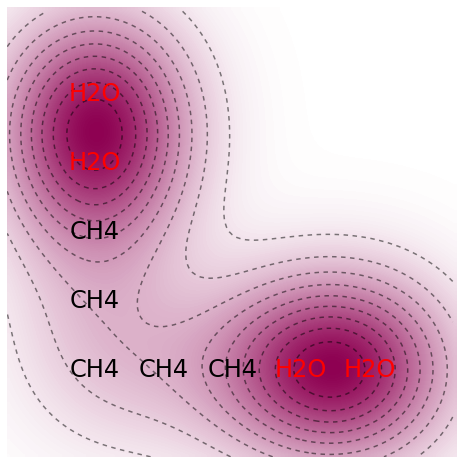

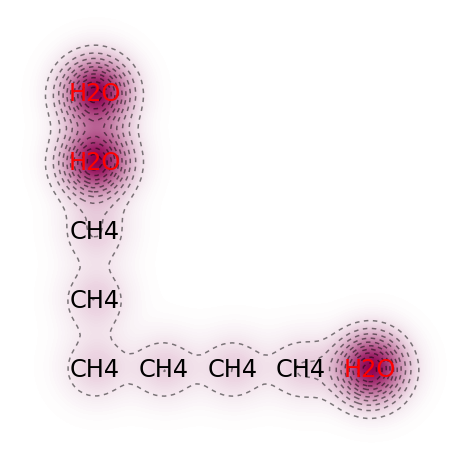

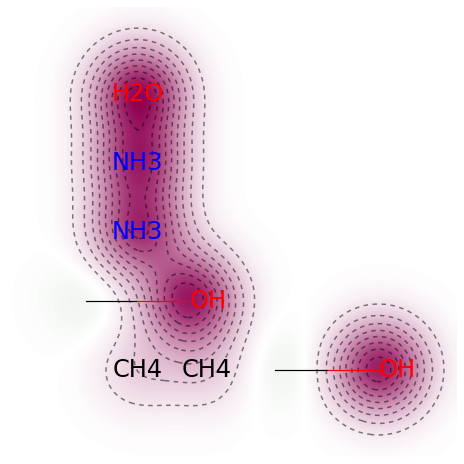

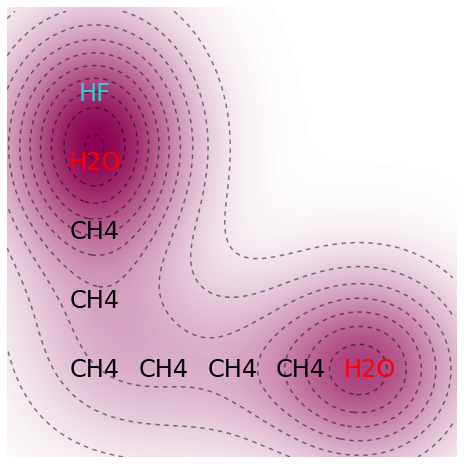

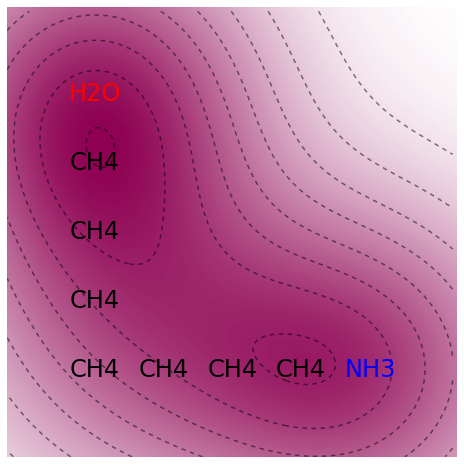

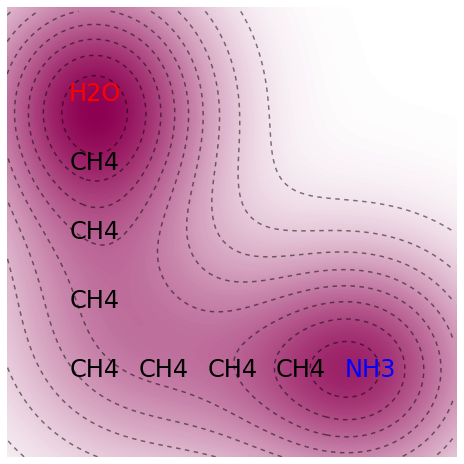

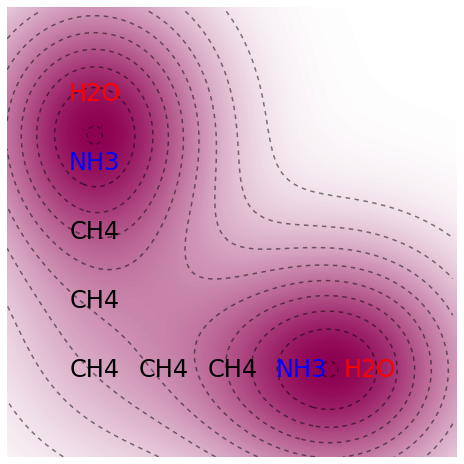

In [ ]:
# Keep only valid moleculues evaluated by RDKit
valid_mols = [i for i in mols if i != None]

from rdkit.Chem.Draw import SimilarityMaps
import matplotlib

for mol in valid_mols:
    AllChem.ComputeGasteigerCharges(mol)
    contribs = [mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol.GetNumAtoms())]
    fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap=None,  contourLines=10)